# <center> My Movie Journey <center>

I like watching movies, and this project is about the movies I have watched so far (as of March 13th, 2021). The notebook includes the following sections:
1. Introduction & Motivation
2. Data Wrangling & Cleaning
3. Exploratory Data Analysis
4. Modeling
5. Demo<br>
Appendix A: User defined modules<br>
Appendix B: Package versions

## 1. Introduction & Motivation

I keep a movie diary on a website called 'letterboxd' (https://letterboxd.com/). Letterboxd (LBD) allows you to keep a record of movies you watched, to rate movies, to write reviews, and to connect with other film lovers. It also allows you to export your LBD profile history as csv files. So, in multiple different csv files, you can find names of the movies you watched, along with your ratings, reviews, etc. It also includes LBD URIs of movies. I thought that I can use these URIs to scrape LBD webpage to extract more information about the movies which are not included in LBD export, such as genre, duration, director, IMDb URL, cast, etc. My motivates in doing so are:
- To discover patterns in my watch history: which genres I watched most, from which countries, etc.
- To spend less time picking a movie out

I cannot emphasize enough the importance of the last point above. More often than not, I spend quite some time to decide on a movie. This thought process is not only time consuming but also draining. I thought if I *learn* from my watch history (including my ratings), I can spend less time when picking out a movie next time. What I have in mind is to build a machine learning model, using movie features as *features* and my rating as a *target variable*. So, when I need to decide whether a movie is worth watching or not, I can use this model to *predict* my rating for it.

The rest of the notebook includes coding, visualizations, modeling, and results. There are a few points to mention before going forward. First, I used IMDb, not LBD, to extract movie features, as the former is more up-to-date than the latter. In order to do that, I scraped LBD pages of movies to get IMDb URLs, and then scraped the IMDb pages. Second, every ..

## 2. Data Wrangling & Cleaning
### 2.1 Import libraries and read data

In [2]:
import os
#wdir="<my working directory>"
#os.chdir(wdir)

# mostly used 
import pandas as pd
import numpy as np

# user defined modules (see Appendix for details)
from imdb_to_df import F_imdb_to_df
from df_to_ml import F_df_to_ml

# for web scraping
from urllib.request import urlopen

# for plots
import matplotlib.pyplot as plt 
import plotly.express as px
import pycountry
import plotly.io as pio
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# to center output (but in notebook only, does NOT apply to html output for some reason!)
from IPython.display import HTML, display

# to save and load ML models
import pickle

# to get package versions
from importlib.metadata import version

In [5]:
raw_df=pd.read_csv("../DATA/ratings.csv") # read Letterboxd export

raw_df.head(3)

,Date,Name,Year,Letterboxd URI,Rating
0,8/20/16,Mondays in the Sun,2002,https://boxd.it/tWs,5.0
1,8/20/16,Bliss,2007,https://boxd.it/1zE2,3.0
2,8/20/16,Black Bread,2010,https://boxd.it/mva,3.5


This file ("ratings.csv") is one of the files exported from LBD. 'Date' column refers the date when you added the movie. 'Name' is the name of the movie, and 'Year' is the release year. 'Letterboxd URI' includes the link for movie page on LBD, and 'Rating' includes my rating (out of 5) for the movie. This rating will be scaled to 10 in the next code chunk in order to be consistent with IMDb rating scale.

Now, I will use this data to create a dataframe that includes more information by scraping IMDB website.

### 2.2 Scrape IMDb website

In [ ]:
### PART 1: scrape Letterboxd website to get IMDb URLs ###

# create an empty list for IMDB URLs
imdb=[]

check_str='http://www.imdb.com/title/tt'

for i in range(raw_df.shape[0]):
    
    link=raw_df['Letterboxd URI'][i]
    f = urlopen(link)
    myfile = f.read()
    a=str(myfile)
    
    # imdb url
    st=a.find(check_str)
    if(st==-1): # no imdb link from letterboxd data (very rare case, but still can happen!)
        continue
    
    ed=a.find("/",st+len(check_str))
    imdb.append(a[st:ed])
  
    # close old connection and delete related variables
    f.close()
    del link,myfile,f,a,st,ed
        

### PART 2:  scrape IMDb website to get features dataframe (df) ###

df=F_imdb_to_df(imdb) # see Appendix for function defintion

# get name and my rating data from raw file
df['name']=raw_df['Name'] # will not be used, but good to have
df['rating_my']=raw_df['Rating']*2 # convert LBD scale to 10

In [2]:
# check data
df.head(3)
df.info() # see column types and missing values

# write file
#pd.DataFrame.to_csv(df,'../DATA/df.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      1119 non-null   object 
 1   director     1119 non-null   object 
 2   year         1119 non-null   int64  
 3   genres       1119 non-null   object 
 4   rating_imdb  1119 non-null   float64
 5   duration     1119 non-null   float64
 6   imdb_url     1119 non-null   object 
 7   name         1119 non-null   object 
 8   rating_my    1119 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 78.8+ KB


## 3. Exploratory Data Analysis

In this section, I will present some data visualizations to have a better feeling of the data. Titles of subsections refer to the feature to be analyzed.

In [3]:
df.head(3)

,country,director,year,genres,rating_imdb,duration,imdb_url,name,rating_my
0,Spain,Fernando León de Aranoa,2002,comedy_drama,7.6,113.0,http://www.imdb.com/title/tt0319769,Mondays in the Sun,10.0
1,Turkey,Abdullah Oguz,2007,drama,7.5,105.0,http://www.imdb.com/title/tt0978649,Bliss,6.0
2,Spain,Agustí Villaronga,2010,crime_drama,6.9,108.0,http://www.imdb.com/title/tt1454523,Black Bread,7.0


### 3. 1 Country

In [4]:
######## MAP by count ##########

# group by country
tab_country=df['name'].groupby(df['country']).count()
a=pd.DataFrame(tab_country)
a = a.reset_index()
a=a.rename(columns={'name':'count'})

## map ##

# fix UK (otherwise it will be coded as Ukraine !)
a.loc[a.country=='UK','country']='England'
# unfortunately, there is no seperate data for UK countries

list_countries = a['country'].unique().tolist()
# print(list_countries) # Uncomment to see list of countries
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        # print('could not add ISO 3 code for ->', country) # uncomment this print anywhere else, not in the notebook
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})
        
# there are 6 country names without ISO code, now we will fix them.
# this 'fix' is just for map illustration, there is no political motivation behind it :)

#Czechoslovakia
a.loc[(a['country']=='Czechoslovakia'),'count']
a.loc[(a['country']=='Czech Republic'),'count']=a.loc[(a['country']=='Czech Republic'),'count']+1
a.loc[(a['country']=='Slovakia'),'count']=a.loc[(a['country']=='Slovakia'),'count']+1
a.drop(a[a.country=='Czechoslovakia'].index,inplace=True)

# Federal Republic of Yugoslavia and Yugoslavia
int(a.loc[(a['country']=='Federal Republic of Yugoslavia'),'count'])+int(a.loc[(a['country']=='Yugoslavia'),'count'])
a.loc[(a['country']=='Bosnia and Herzegovina'),'count']=a.loc[(a['country']=='Bosnia and Herzegovina'),'count']+4
a.loc[(a['country']=='Croatia'),'count']=a.loc[(a['country']=='Croatia'),'count']+4
a.loc[(a['country']=='Serbia'),'count']=a.loc[(a['country']=='Serbia'),'count']+4
a.drop(a[a.country=='Federal Republic of Yugoslavia'].index,inplace=True)
a.drop(a[a.country=='Yugoslavia'].index,inplace=True)

# South Korea
a.loc[a.country=='South Korea','country']='Korea, Republic of'

#Soviet Union
a.loc[(a['country']=='Russia'),'count']=a.loc[(a['country']=='Russia'),'count']+int(a.loc[(a['country']=='Soviet Union'),'count'])
a.drop(a[a.country=='Soviet Union'].index,inplace=True)

# West Germany
a.loc[(a['country']=='Germany'),'count']=a.loc[(a['country']=='Germany'),'count']+int(a.loc[(a['country']=='West Germany'),'count'])
a.drop(a[a.country=='West Germany'].index,inplace=True)

# reset index
a.reset_index(drop=True,inplace=True)


# re-run the dictionary for codes

list_countries = a['country'].unique().tolist()
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        # print('could not add ISO 3 code for ->', country)
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})

# create a new column iso_alpha in the df
# and fill it with appropriate iso 3 code
for k, v in d_country_code.items():
    a.loc[(a.country == k), 'iso_alpha'] = v

# filter for countries with n movies or more
n=4
b=a[a['count']>=n]

# these two lines are needed to show output map within the notebook

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

fig = px.choropleth(data_frame = b,
                    locations= "iso_alpha",
                    color= "count",
                    hover_name= "country",
                    color_continuous_scale= 'Sunset')

fig.update_layout(
    title={
        'text': 'Movies by Country <br> (countries with less than '+ str(n)+' movies are excluded)',
        'y':.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})



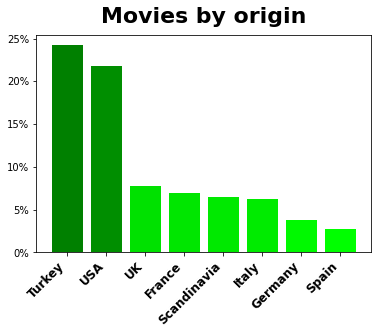

In [22]:
####### Bar Plot of top countries ###########

## bar plot ##

# group scandinavian countries, as they mostly appear together 
count_scan=sum(a[a['country'].isin(['Denmark','Norway','Sweden'])]['count'])
a.loc[a.shape[0]]=['Scandinavia',count_scan,'SCA']
a.drop(a[a.country.isin(['Denmark','Norway','Sweden'])].index,inplace=True)
a['perc']=round(a['count']/sum(a['count'])*100,1)
b=a.sort_values(by='perc',ascending=False)

# get top countries that account for 2% or more of all countries
most_country=list(b.loc[b['perc']>=2,'country'])
b=b[b.country.isin(most_country)]

# switch back from England to UK
b.loc[b.country=='England','country']='UK'

# remove unnecessary cols
b.drop(['count','iso_alpha'],axis=1,inplace=True)
b.set_index('country',inplace=True)

# pick tones of colors for different weights
data_normalizer = Normalize()
color_map = LinearSegmentedColormap( # only tones of green will be applied
    "my_map",
    { 
        "green": [(0, 1, 1.0),
                (1.0, .5, .5)],

        "red": [(0, 0, 0),
                  (1.0, 0, 0)],

        "blue": [(0, 0, 0),
                 (1.0, 0, 0)]
    }

)

# plot
plt.bar(b.index,b.perc,
        color=color_map(data_normalizer(b.perc)))

plt.xticks(rotation=45, ha='right',
           fontsize=12,fontweight='semibold')

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100,
                                                     decimals=0))

plt.title(label='Movies by origin',
             pad=12,
             fontdict={'fontsize':22,'fontweight':'bold'})

plt.show()                          
plt.close()

#plt.savefig('bar_country.png', dpi=200,bbox_inches = "tight")





### 3.2 Genre

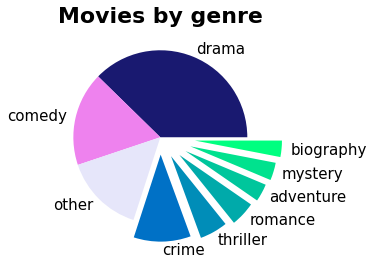

In [23]:
# group by genre
tab_genre=df['name'].groupby(df['genres']).count()
a=pd.DataFrame(tab_genre)
a = a.reset_index()
a=a.rename(columns={'name':'count'})

# split multiple genres
# example: if there are three genres as 'comedy', 'comedy_drama', and 'action'
# then, 'comedy' will be 50%, 'drama' will be 25%, and 'action' will be 25%
genlist=list()
for i in range(df.shape[0]):
    x=df.genres[i]
    genlist.extend(x.split("_"))
genlist=list(set(genlist))

genre_df= pd.DataFrame(columns=['count'])
genre_df['genre']=genlist

for i in range(len(genlist)):
    genre_df.loc[i,'count']=sum(df['genres'].str.contains(genlist[i]))

genre_df['share']=genre_df['count']/sum(genre_df['count'])
genre_df.sort_values('share',ascending=False,inplace=True)

# get top n and label others as 'Other'
n=8
topgen=list(genre_df.genre[:n])
other_share=1-sum(genre_df.share[genre_df.genre.isin(topgen)])

genre_df=genre_df[genre_df.genre.isin(topgen)]
genre_df=genre_df.reset_index(drop=True)
genre_df.loc[genre_df.shape[0]]=[1,'other',other_share] # count is not important


# pie chart

genre_df.set_index(genre_df.genre,drop=True,inplace=True)
group_names = list(genre_df.index)

counts = genre_df.share

counts=counts.sort_values(ascending=False)

explist=[0,0,0,.2,.25,.3,.33,.36,.4]

colors = ['#191970', '#EE82EE','#E6E6FA',
          '#0071C6', '#008DB8','#00AAAA',
          '#00C69C', '#00E28E', '#00FF80']

counts.plot(kind='pie', 
            fontsize=15, 
            colors=colors, 
            explode=explist)

plt.title("Movies by genre",
           fontdict={'fontsize':22,'fontweight':'bold'})
plt.ylabel("")

#plt.savefig('pie_genre.png', dpi=200,bbox_inches = "tight")

plt.show()
plt.close()



### 3.3 Director

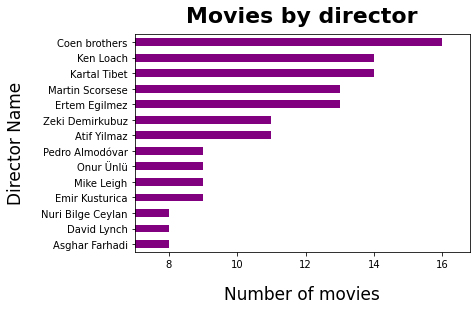

In [10]:
# group by director
tab_dir=df['name'].groupby(df['director']).count()
a=pd.DataFrame(tab_dir)
a = a.reset_index()
a=a.rename(columns={'name':'count'})

# adjust for coen brothers
tot=int(a.loc[(a['director']=='Ethan Coen'),'count'])+int(a.loc[(a['director']=='Joel Coen'),'count'])
a.loc[a.shape[0]]=['Coen brothers',tot]
a.drop(a[a.director.isin(['Ethan Coen','Joel Coen'])].index,inplace=True)

# pick directors with at least n movies
n=8
b=a.drop(a[a['count']<n].index)
b.set_index('director',inplace=True)

b.sort_values(by='count',inplace=True,ascending=True)

ax=b.plot.barh(color='purple')
ax.set_xlabel(xlabel="Number of movies",
              labelpad=16,
              fontdict={'fontsize':17})

ax.get_legend().remove()

ax.set_xlim(left=7)

ax.set_ylabel(ylabel="Director Name",
              labelpad=16,
              fontdict={'fontsize':17})
ax.set_title(label='Movies by director',
             pad=12,
             fontdict={'fontsize':22,'fontweight':'bold'})

fig = ax.get_figure()

#fig.savefig('bar_director.png', dpi=200,bbox_inches = "tight")


### 3.4 Duration

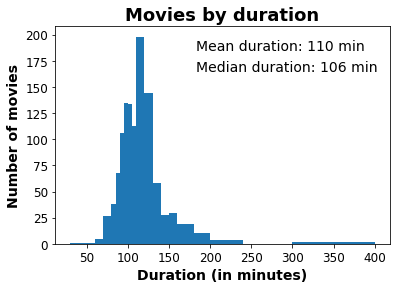

In [12]:
# duration intervals
durbin=np.array([30,60,70,80,85,90,95,100,105,
                 110,120,130,140,150,160,180,200,240,300,400])
plt.hist(df.duration,bins=durbin)
plt.xlabel("Duration (in minutes)",fontsize=14,fontweight='semibold')
plt.ylabel("Number of movies",fontsize=14,fontweight='semibold')
plt.title("Movies by duration",fontsize=18,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# legend
me=round(np.mean(df.duration))
md=round(np.median(df.duration))

#create legend with empty handles
r = Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)
labels=['Mean duration: '+str(me)+' min','Median duration: '+str(md)+' min']
plt.legend([r,r], labels,frameon=False,fontsize=14)

plt.show()
plt.close()

#plt.savefig('hist_duration.png', dpi=200,bbox_inches = "tight")



### 3.5 Rating

Ratings (both IMDb and mine) are the most important attributes in the data, as my main aim is to build a model to predict my future rating for movies. So, this section will include more visuals than previous ones.

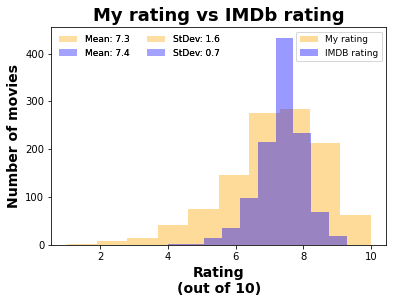

In [24]:
### My rating vs IMDb rating ###

# plot overlapping histogram
plt.hist(df.rating_my, alpha=0.4, label="My rating",color='orange')
plt.hist(df.rating_imdb, alpha=0.4, label="IMDB rating",color='blue')

# add labels and title
plt.xlabel("Rating\n(out of 10)",fontsize=14,fontweight='semibold')
plt.ylabel("Number of movies",fontsize=14,fontweight='semibold')
plt.title("My rating vs IMDb rating",fontsize=18,fontweight='bold')

# add first legend
plt.gca().add_artist(plt.legend(loc='upper right',
                                fontsize=9))


# add second legend
labels=['Mean: '+str(round(np.mean(df.rating_my),1)),
        'Mean: '+str(round(np.mean(df.rating_imdb),1)),
        'StDev: '+str(round(np.std(df.rating_my),1)),
        'StDev: '+str(round(np.std(df.rating_imdb),1))]

leg=plt.gca().add_artist(plt.legend(labels,
                                frameon=False,
                                fontsize=9,
                                ncol=2))
for lh in leg.legendHandles: 
    lh.set_alpha(.2)

plt.show()
plt.close()
    
#plt.savefig('hist_ratings.png', dpi=200,bbox_inches = "tight")


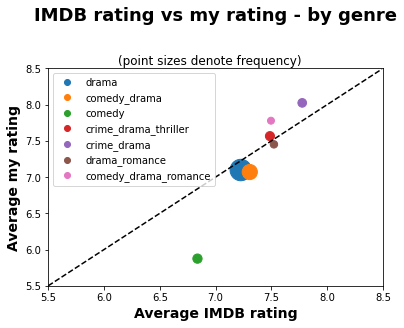

In [51]:
### Ratings by genre ###

# Note: genres here are in the original format (i.e. 'comedy_drama_action'), not seperated!

# group by genre
tab_genre=df['name'].groupby(df['genres']).count()
a=pd.DataFrame(tab_genre)
a.reset_index(inplace=True)
a=a.rename(columns={'name':'count'})
a['perc']=a['count']/sum(a['count'])*100


# get top n genres by percentage
n=7
a.sort_values(by='perc',ascending=False,inplace=True)
b=a.iloc[:n,:]
b.reset_index(inplace=True,drop=True)

temp=df.loc[df.genres.isin(b.genres)]
rating_genre=pd.DataFrame(temp[['rating_my','rating_imdb']].groupby(temp['genres']).mean())
rating_genre.reset_index(inplace=True)
b=b.merge(rating_genre)


# scatter plot
colorlist=['#1f77b4', '#ff7f0e', '#2ca02c', 
               '#d62728', '#9467bd', '#8c564b', 
               '#e377c2']

plt.scatter(b.rating_imdb,b.rating_my,
            s=b.perc*20,
            c=colorlist)

plt.xlim(5.5,8.5)
plt.ylim(5.5,8.5)

# add 45 degree line
x=np.arange(5.5,8.5,.01)
plt.plot(x,x,color='black',linestyle='dashed')

# add labels
plt.xlabel("Average IMDB rating",fontsize=14,fontweight='semibold')
plt.ylabel("Average my rating",fontsize=14,fontweight='semibold')

# add title
plt.title("IMDB rating vs my rating - by genre\n\n",
          fontsize=18,fontweight='bold')

# add second line of title
plt.suptitle('\n(point sizes denote frequency)', fontsize=12)

# add legend
leg_hand=list()
for i in range(b.shape[0]):
    leg_hand.append(mlines.Line2D([], [], color=colorlist[i], marker='o', ls='', label=b.genres[i]))

plt.legend(handles=leg_hand,loc='upper left')
plt.show()
plt.close()

#plt.savefig('scatter_ratingbygenre.png', dpi=200,bbox_inches = "tight")

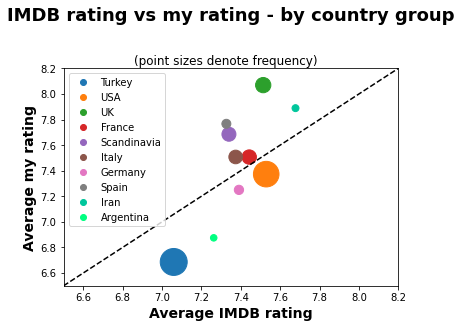

In [25]:
### Ratings by country group ###

# group by country
tab_country=df['name'].groupby(df['country']).count()
a=pd.DataFrame(tab_country)
a.reset_index(inplace=True)
a=a.rename(columns={'name':'count'})

# adjust Scandinavia
count_scan=sum(a[a['country'].isin(['Denmark','Norway','Sweden'])]['count'])
a.loc[a.shape[0]]=['Scandinavia',count_scan]
a.drop(a[a.country.isin(['Denmark','Norway','Sweden'])].index,inplace=True)

# calculate percentage
a['perc']=a['count']/sum(a['count'])*100
a.sort_values(by='perc',ascending=False,inplace=True)
a.reset_index(inplace=True)

pd.set_option('mode.chained_assignment', None) # to supress irregular warning!

# get top n and label others as 'Other'
n=10
a.sort_values(by='perc',ascending=False,inplace=True)
b=a.iloc[:n,:]
b.reset_index(inplace=True,drop=True)

temp=df.loc[df.country.isin(list(b.country)+['Denmark','Norway','Sweden'])]

temp.loc[temp.country.isin(['Denmark','Norway','Sweden']),'country']='Scandinavia'

rating_country=pd.DataFrame(temp[['rating_my','rating_imdb']].groupby(temp['country']).mean())
rating_country.reset_index(inplace=True)
b=b.merge(rating_country)


# scatter plot

colorlist=['#1f77b4', '#ff7f0e', '#2ca02c', 
               '#d62728', '#9467bd', '#8c564b', 
               '#e377c2', '#7f7f7f','#00C69C', '#00FF80']

plt.scatter(b.rating_imdb,b.rating_my,
            s=b.perc*30,
            c=colorlist)

plt.xlim(6.5,8.2)
plt.ylim(6.5,8.2)

x=np.arange(6.5,8.5,.01)

plt.plot(x,x,color='black',linestyle='dashed')

plt.xlabel("Average IMDB rating",fontsize=14,fontweight='semibold')
plt.ylabel("Average my rating",fontsize=14,fontweight='semibold')

plt.title("IMDB rating vs my rating - by country group\n\n",
          fontsize=18,fontweight='bold')

plt.suptitle('\n(point sizes denote frequency)', fontsize=12)

leg_hand=list()
for i in range(b.shape[0]):
    leg_hand.append(mlines.Line2D([], [], color=colorlist[i], marker='o', ls='', label=b.country[i]))


plt.legend(handles=leg_hand,loc='upper left')
plt.show()
plt.close()
# plt.savefig('scatter_ratingbycountry.png', dpi=200,bbox_inches = "tight")


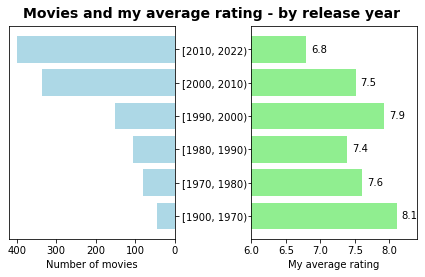

In [70]:
### My rating by release year ###

# this part is needed to center plots
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# create bins
bins=np.array(1900)
bins=np.append(bins,np.arange(1970,2020,10))
bins=np.append(bins,2022)

# group by year
tab_count=df['name'].groupby(pd.cut(df['year'], bins,right=False)).count()
tab_rating=df['rating_my'].groupby(pd.cut(df['year'], bins,right=False)).mean()

y=list(tab_count.index.astype(str))
x1=tab_count.values
x2=tab_rating.values

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(y, x1, align='center', color='lightblue')
axes[1].barh(y, x2, align='center', color='lightgreen')
axes[1].set_xlim(6,8.4)

axes[0].set_xlabel("Number of movies")
axes[1].set_xlabel("My average rating")

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=y)
axes[0].yaxis.tick_right()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(wspace=0.46)

fig.suptitle("Movies and my average rating - by release year",
             fontsize=14,
             fontweight='bold')

rects = axes[1].patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()
plt.close()

#plt.savefig('hbar2_ratingbyyear.png', dpi=200,bbox_inches = "tight")

## 4. Modeling

The first section includes encoding for categorical variables, and then splitting data into train and test sets. Then I will train three machine learning models, with 4-fold cross-validation. Finally, in the last section, I will present the results, pick the best model, and then train the best model on whole data set.

### 4.1 Group features and organize data to feed ML models

In [6]:
### Year

# different bins than previous (to decrease number of features)
bins_year=np.array(1900)
bins_year=np.append(bins_year,np.arange(1970,2020,10))
bins_year=np.append(bins_year,2022)
names_year = ['before70','70s','80s','90s','2000s','2010s']


### Country

# group by country
tab_country=df['name'].groupby(df['country']).count()
a=pd.DataFrame(tab_country)
a.reset_index(inplace=True)
a=a.rename(columns={'name':'count'})

# adjust Scandinavia, as they appear together mostly
count_scan=sum(a[a['country'].isin(['Denmark','Norway','Sweden'])]['count'])
a.loc[a.shape[0]]=['Scandinavia',count_scan]
a.drop(a[a.country.isin(['Denmark','Norway','Sweden'])].index,inplace=True)

# get top n and label others as 'Other'
n=6
a.sort_values(by='count',ascending=False,inplace=True)
tops=list(a.country[:n])
others=list(set(a.country)-set(tops))
sc=['Denmark','Norway','Sweden'] # is part of tops

# mapping for country
cmapping1 = {i:i for i in [t for t in tops if t != 'Scandinavia']}
cmapping2={i:'Scandinavia' for i in sc}
cmapping3 = {i:'other_country' for i in others}
mapping_country = {**cmapping1, **cmapping2,**cmapping3}


### Genres

# group by genre
tab_genres=df['name'].groupby(df['genres']).count()
a=pd.DataFrame(tab_genres)
a.reset_index(inplace=True)
a=a.rename(columns={'name':'count'})
a.sort_values(by='count',ascending=False,inplace=True)

# get top n and label others as 'Other'
n=9
tops=list(a.genres[:n])
others=list(set(a.genres)-set(tops))

# mapping for genre
cmapping1 = {i:i for i in tops}
cmapping2 = {i:'other_genre' for i in others}
mapping_genre = {**cmapping1, **cmapping2}



#### Create ML data (see appendix for function defintion)

anydf=df.copy()
mldf=F_df_to_ml(anydf,
                mapping_country,
                mapping_genre,
                bins_year,
                names_year)

Y=mldf.rating_my # target values
X=mldf.drop('rating_my', axis=1) # feature matrix

# train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3006)

# we may need this order if XGB is chosen as the best model
testcol_order=list(x_test.columns)

### 4.2  Train ML models

In [7]:
numfeat=x_train.shape[1] # number of features
cv_nfold=4 # number of folds for cross validation

### Random Forest Regressor ###

# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 400, stop = 800, num = 30)],
               'max_features': [int(x) for x in np.linspace(start = numfeat/6, stop = numfeat/2, num = 8)],
               'max_depth':  [x*2 for x in range(2,7)],
               'min_samples_split': [x for x in range(3,7)],
               'min_samples_leaf': [x for x in range(3,7)]}


# First create the base model to tune
rf_reg = RandomForestRegressor(random_state = 1903)

# Randomized search
rf_cv = RandomizedSearchCV(estimator = rf_reg, 
                               param_distributions = random_grid,
                               n_iter = 150, 
                               cv = cv_nfold, 
                               verbose=0, # silent
                               n_jobs = -1, # use all processors (causes fans to make noise!)
                               scoring='neg_mean_squared_error',
                               random_state=1001)

# Fit the model
rf_cv.fit(x_train, y_train)

# if you would like to see best parameters selected
# rf_cv.best_params_

# predict
y_pred = np.round(rf_cv.predict(x_test),1)
mse_rf = round((mean_squared_error(y_test, y_pred)),3) # getting score


#####################


### XGB Regressor ###

random_grid={'eta':[x for x in np.linspace(.02,.3,num=20)],
        'min_child_weight':[i for i in range(2,6)], 
        'gamma':[i/10.0 for i in range(2,20)],  
        'subsample':[i/10.0 for i in range(6,11)],
        'colsample_bytree':[i/10.0 for i in range(6,11)], 
        'max_depth': [i*2 for i in range(2,7)]}

xg_reg = xgb.XGBRegressor(random_state=808)

xgb_cv =  RandomizedSearchCV(estimator = xg_reg, 
                               param_distributions = random_grid,
                               n_iter = 150, 
                               cv = cv_nfold, 
                               verbose=0, # silent
                               n_jobs = -1, # use all processors (causes fans to make noise!)
                               scoring='neg_mean_squared_error',
                               random_state=1001)

xgb_cv.fit(x_train,y_train)

# if you would like to see best parameters selected
# xgb_cv.best_params_

y_pred = xgb_cv.predict(x_test) #predict

mse_xgb = round((mean_squared_error(y_test, y_pred)),3) # getting score

### 4.3 The best model

In [15]:
print("Random Forest MSE:",mse_rf)
print("XGB MSE:",mse_xgb)

if(mse_rf<=mse_xgb):
    best_model=rf_cv
    bestML="Random Forest"
else:
    best_model=xgb_cv
    bestML="XGB"

print("So, the best model is ",bestML)

# train best model on whole data set
best_model.fit(X,Y)


# save the best model
f = open('best_model.sav', 'wb')
pickle.dump(best_model, f)
f.close() # do NOT forget to close (otherwise you will have problems)

# save other variables needed to predict new data
f = open('obj.pkl', 'wb')
pickle.dump([mapping_country,
                mapping_genre,
                bins_year,
                names_year,
                testcol_order],f)
f.close()

Random Forest MSE: 1.967
XGB MSE: 1.961
So, the best model is  XGB


## 5. Demo

Ok, now we come to the fun part :) I will feed our model with IMDb link for any movie, and it will tell me whether or not I will like the movie.

In [16]:
# load the model from disk
f = open('best_model.sav', 'rb')
loaded_model = pickle.load(f)
f.close()

# load objects
f = open('obj.pkl', 'rb')
obj1, obj2, obj3, obj4, obj5 = pickle.load(f)
f.close()

# I look forward to seeing this movie actually
imdb_link='https://www.imdb.com/title/tt11655202'

# extract features from IMDb website
newdf=F_imdb_to_df(imdb_link)

# create data for ML
anydf=newdf.copy()
new_test=F_df_to_ml(anydf,obj1, obj2, obj3, obj4, obj5)

# predict my rating
new_rating=round(loaded_model.predict(new_test)[0],1)

if 8<=new_rating<=10:
    likefilm="DEFINITELY"
elif (7<=new_rating<8):
    likefilm="MOST PROBABLY"
elif (6<=new_rating<7):
    likefilm="MAYBE"
elif (4<=new_rating<6):
    likefilm="NOT"
else:
    likefilm="DEFINITELY NOT"

print("Your rating is",str(new_rating),"\nYou will "+likefilm+" like this movie!")



Your rating is 8.1 
You will DEFINITELY like this movie!


Well, it works!!

## Appendix A: User defined modules

In [13]:
def F_imdb_to_df(IMDb_URLs):
    
    
    """
    This function receives IMDb link(s) (either only one as a string or multiple as a series)
    And then scrapes IMDb website to extract featues of the movie(s)
    """
    
    import pandas as pd
    from urllib.request import urlopen
        
    colnames=['country',
              'director',
              'year',
              'genres',
              'rating_imdb',
              'duration']
    
       
    df= pd.DataFrame(columns=colnames)
    
    if(type(IMDb_URLs)==str):
        IMDb_URLs=[IMDb_URLs]
        
    df['imdb_url']=IMDb_URLs
 
    
    for i in range(df.shape[0]):
        
        # open imdb url
        imdb_link=df.loc[i,'imdb_url']
        f = urlopen(imdb_link)
        myfile = f.read()
        a=str(myfile,encoding='utf-8')
        
        # close connection and delete related variables
        f.close()
        del myfile, f, imdb_link
          
        # only the first country
        check_str='country_of_origin'
        st=a.find(check_str) 
        if(st!=-1):
            ed1=a.find(">",st+len(check_str))
            ed2=a.find("<",ed1)
            df.loc[i,'country']=a[(ed1+1):ed2]
        
        
        # only the first director
        check_str='"director": {'
        st=a.find(check_str)
        if(st==-1): # if there are more than one director, pattern will be different
            check_str='"director": ['
            st=a.find(check_str)
        
        if(st!=-1):
            ed1=a.find('"name": "',st+len(check_str))
            ed2=a.find('"',ed1+9)
            df.loc[i,'director']=a[ed1+9:ed2]
        
        # year
        check_str='"titleYear"'
        st=a.find(check_str)
        if(st!=-1):
            ed1=a.find('year',st+len(check_str)+1)
            df.loc[i,'year']=int(a[ed1+5:ed1+9])
        
        # genres (only first three genres)
        all_genre=list()
        check_str='title?genres'
        st=a.find(check_str)
        if(st!=-1):
            ed=a.find('&',st+len(check_str)+1)
            all_genre.append(a[(st+len(check_str)+1):ed])
            st2=a.find('title?genres',ed,ed+100)
            if(st2!=-1):
                 ed2=a.find('&',st2+len(check_str)+1)
                 all_genre.append(a[(st2+len(check_str)+1):ed2])
                 st3=a.find('title?genres',ed2,ed2+100)
                 if(st3!=-1):
                     ed3=a.find('&',st3+len(check_str)+1)
                     all_genre.append(a[(st3+len(check_str)+1):ed3])
            
        all_genre.sort()
        df.loc[i,'genres']='_'.join(all_genre) 
        
        
        # imdb rating
        check_str='span class="rating">'
        st=a.find(check_str)
        ed=a.find('<',st+len(check_str))
        if(st!=-1):
            df.loc[i,'rating_imdb']=float(a[st+len(check_str):ed])
            
        # duration
        check_str='duration'
        st=a.find(check_str) 
        if(st!=-1):
            ed1=a.find('"PT' ,st+len(check_str))
            ed2=a.find("H",ed1,ed1+10)
            if(ed2!=-1):
                ed3=a.find("M",ed1,ed1+10)
                if(ed3!=-1): # both hour and minute
                    dur_str=a[ed1+3:ed3]
                    df.loc[i,'duration']=int(dur_str[0])*60+int(dur_str[2:])
                else: # no minute
                    df.loc[i,'duration']=int(a[ed2-1])*60
            else: # no hour
                df.loc[i,'duration']=int(a[ed1+3:ed1+5])
                

    df.duration=df.duration.astype(float)
    df.rating_imdb=df.rating_imdb.astype(float)
    df.year=df.year.astype(float)

    return(df)
    
    #### 
 

In [14]:
def F_df_to_ml(anydf,
               mapping_country,
               mapping_genre,
               bins_year,
               names_year,
               col_order=None
               ):
    
    
    """
    This function makes data ready to feed ML models.
    It encodes categorical variables 'country' and 'genre', and convert 'year' to bins.
    """
    
    import pandas as pd
    
    anydf['YearRange'] = pd.cut(anydf['year'], bins_year, labels=names_year)
    anydf['country_mapped'] = anydf.country.map(mapping_country)
    anydf['genres_mapped'] = anydf.genres.map(mapping_genre)
    
    if('name' in anydf.columns):
        remcols=['imdb_url','name','director','year','country','genres']
    else:
        remcols=['imdb_url','director','year','country','genres']

    anydf.drop(remcols,axis=1,inplace=True)
    
    anydf['country_mapped'] = anydf['country_mapped'].astype('category')
    anydf['genres_mapped'] = anydf['genres_mapped'].astype('category')
    anydf['YearRange']=anydf['YearRange'].astype('category')
    
    # Get one hot encoding of 
    one_hot_country = pd.get_dummies(anydf['country_mapped'],prefix='C')
    one_hot_genre = pd.get_dummies(anydf['genres_mapped'],prefix='G')
    one_hot_year = pd.get_dummies(anydf['YearRange'],prefix='Y')
    
    # do NOT drop first column unless you are using 
    # linear regression, or generalized linear models estimated by maximum likelihood (or least squares) 
    
    # Drop columns that are encoded
    anydf = anydf.drop(['country_mapped','genres_mapped','YearRange'],axis = 1)
    # Join the encoded anydf
    anydf = anydf.join([one_hot_country,one_hot_genre,one_hot_year])
    
    # all dfs should include these dummy columns, needed to predict new data
    if(col_order!=None):
        mis_cols=list(set(col_order)-set(list(anydf.columns)))
        if(len(mis_cols)>0):
            anydf[mis_cols]=0
        anydf=anydf[col_order] # also columns must be in order for XGB to predict!!
        
        
    return(anydf)

## Appendix B: Package versions

In [28]:
modules=['pandas',
         'numpy',
         'matplotlib',
         'plotly',
         'pycountry',
         'scikit-learn',
         'xgboost',
         'urllib3']

moddf=pd.DataFrame(modules,columns=['Package'])
moddf['Version']=[version(m) for m in modules]

print(moddf.to_string(index=False))

      Package  Version
       pandas    1.1.3
        numpy   1.19.2
   matplotlib    3.3.2
       plotly   4.14.3
    pycountry   20.7.3
 scikit-learn   0.23.2
      xgboost    1.1.1
      urllib3  1.25.11
